# Lab 5 - Diffusion

In [44]:
import torch
import torch.nn as nn
import math
import matplotlib.pyplot as plt

### Some preliminary data observations

In [9]:
bicycle = []

with open("bicycle.txt") as file:
    lines = file.readlines()
    bicycle = [(float(line.split()[0]), float(line.split()[1])) for line in lines]

bicycle = torch.Tensor(bicycle)
bicycle

tensor([[ 0.2370,  1.0000],
        [ 0.2399,  1.0000],
        [ 0.2428,  1.0000],
        ...,
        [ 0.6705, -0.9954],
        [ 0.6734, -0.9954],
        [ 0.6358, -1.0000]])

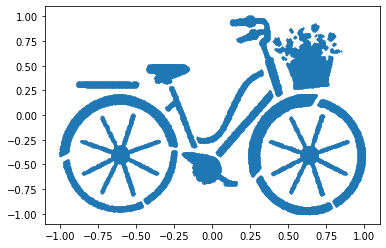

In [13]:
plt.scatter(bicycle[:, 0], bicycle[:, 1], s=1)

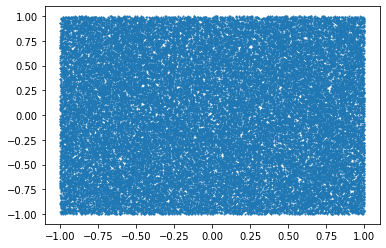

In [14]:
random_pointcloud = torch.rand(bicycle.shape) * 2 - 1
plt.scatter(random_pointcloud[:, 0], random_pointcloud[:, 1], s=1)

### Forward diffusion

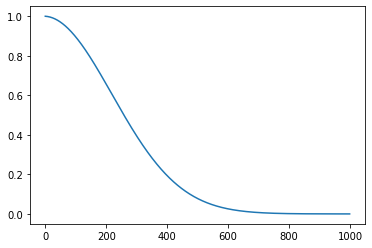

In [16]:
STEPS = 1000
beta = torch.linspace(0.0001, 0.02, STEPS)
alfa = 1 - beta
alfa_product = torch.clone(alfa)
for i in range(1, len(alfa_product)):
    alfa_product[i] = alfa_product[i - 1] * alfa_product[i]

plt.plot(torch.arange(0, STEPS), alfa_product)

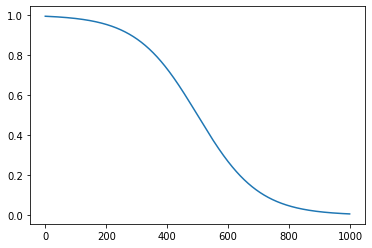

In [25]:
alfa_product = torch.sigmoid(torch.linspace(5, -5, 1000))
plt.plot(torch.arange(0, STEPS), alfa_product)

In [27]:
for i in range(1, len(alfa_product)):
    alfa[i] = alfa_product[i] / alfa_product[i - 1]

beta = 1 - alfa

In [32]:
def diffusion(batch: torch.Tensor, alfa_product: torch.Tensor, t: int) -> torch.Tensor:
    mean = torch.sqrt(alfa_product[t]) * batch
    std = (1 - alfa_product[t]) * torch.ones(batch.shape)

    samples = torch.normal(mean, std)

    return samples

In [33]:
input = torch.rand([2, bicycle.shape[0], bicycle.shape[1]]) * 2 - 1
input.shape

torch.Size([2, 50468, 2])

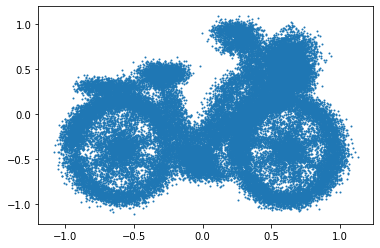

In [41]:
diffused_bicycle = diffusion(bicycle, alfa_product, 200)
plt.scatter(diffused_bicycle[:, 0], diffused_bicycle[:, 1], s=1)

Diffusion works, we can melt the bicycle!

### DDPM - Denoising Diffusion Probabilistic Model

In [47]:
# https://github.com/wzlxjtu/PositionalEncoding2D/blob/master/positionalembedding2d.py
def positionalencoding1d(d_model, length):
    """
    :param d_model: dimension of the model
    :param length: length of positions
    :return: length*d_model position matrix
    """
    if d_model % 2 != 0:
        raise ValueError(
            "Cannot use sin/cos positional encoding with "
            "odd dim (got dim={:d})".format(d_model)
        )
    pe = torch.zeros(length, d_model)
    position = torch.arange(0, length).unsqueeze(1)
    div_term = torch.exp(
        (
            torch.arange(0, d_model, 2, dtype=torch.float)
            * -(math.log(10000.0) / d_model)
        )
    )
    pe[:, 0::2] = torch.sin(position.float() * div_term)
    pe[:, 1::2] = torch.cos(position.float() * div_term)

    return pe

In [57]:
class DDPM(nn.Module):
    def __init__(self):
        super(DDPM, self).__init__()
        self.no_of_layers = 4
        self.d_model = 128
        self.encoding_length = 50
        self.input_size = 2

        self.encoding = positionalencoding1d(self.encoding_length, 1000)

        self.layers = nn.ModuleList(
            [nn.Sequential(nn.Linear(self.input_size, self.d_model), nn.ReLU())]
            + [
                nn.Sequential(nn.Linear(self.d_model, self.d_model), nn.ReLU())
                for _ in range(self.no_of_layers - 1)
            ]
            + [nn.Linear(self.d_model, self.d_model)]
        )

        self.learnable_sinusoidal_embeddings = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Linear(self.encoding_length, self.d_model),
                    nn.ReLU(),
                    nn.Linear(self.d_model, self.d_model),
                )
                for _ in range(self.no_of_layers)
            ]
        )

    def forward(self, x, t):
        output = x
        for i in range(self.no_of_layers):
            output = self.layers[i](output) + self.learnable_sinusoidal_embeddings[i](
                self.encoding[t]
            )
            if i < self.no_of_layers - 1:
                output = nn.ReLU()(output)

        return output


model = DDPM()
model(input, 20).shape

torch.Size([2, 50468, 128])